# Generate Paper Figures

In [1]:
from glob import glob
from scipy.optimize import least_squares
from waveCal import *

## Gather Files

In [2]:
# LFC
lfc_files = glob('/mnt/home/lzhao/ceph/lfc5*/LFC_*.fits')
ckpt_files = glob('/mnt/home/lzhao/ceph/ckpt5*/LFC_19*.npy')
lfc_files, lfc_times = sortFiles(lfc_files, get_mjd=True)
ckpt_files = sortFiles(ckpt_files)
num_lfc_files = len(lfc_files)

hdus = fits.open(lfc_files[0])
t_spec = hdus[1].data['spectrum'].copy()
t_errs = hdus[1].data['uncertainty'].copy()
t_mask = hdus[1].data['pixel_mask'].copy()
hdus.close()
nord, npix = t_spec.shape

lfc_orders = range(45,76)

In [3]:
# ThAr
thar_files = glob('/mnt/home/lzhao/ceph/thar5*/ThAr_*.fits')
thid_files  = glob('/mnt/home/lzhao/ceph/thid5*/ThAr_*.thid')
thar_files, thar_times = sortFiles(thar_files, get_mjd=True)
thar_files = thar_files[1:] # First file is from before LFCs
thar_times = thar_times[1:]
thid_files = sortFiles(thid_files) [1:]
num_thar_files = len(thar_files)

## Results

### Self Tests

### Training and Validation Tests

In [4]:
np.random.seed(0)
# Make sure validation exposures are not first or last exposure
valid_idx = np.random.choice(num_lfc_files-2, num_lfc_files//10, replace=False)+1

lfc_train = np.delete(ckpt_files,valid_idx)
lfc_times_train = np.delete(lfc_times,valid_idx)
time_sort = np.argsort(lfc_times_train)
lfc_train = lfc_train[time_sort]
lfc_times_train = lfc_times_train[time_sort]

lfc_valid = ckpt_files[valid_idx]
lfc_times_valid = lfc_times[valid_idx]
time_sort = np.argsort(lfc_times_valid)
lfc_valid = lfc_valid[time_sort]
lfc_times_valid = lfc_times_valid[time_sort]

In [5]:
np.random.seed(0)
valid_idx = np.random.choice(num_thar_files-2, num_thar_files//10, replace=False)+1

thar_train = np.delete(thid_files,valid_idx)
thar_times_train = np.delete(thar_times,valid_idx)
time_sort = np.argsort(thar_times_train)
thar_train = thar_train[time_sort]
thar_times_train = thar_times_train[time_sort]

thar_valid = thid_files[valid_idx]
thar_times_valid = thar_times[valid_idx]
time_sort = np.argsort(thar_times_valid)
thar_valid = thar_train[time_sort]
thar_times_valid = thar_times_valid[time_sort]

### Cross Tests

## Comparisons to Other Methods
Since neither of the methods we are comparing to are hierarchical, we only need one example ckpt/thid file.  However, it should be a file in the validation set to make it easier to draw comparisons with all the tests.

In [6]:
title_font = 18
label_font = 14

In [7]:
ckpt_test = lfc_valid[10]
thid_test = thar_valid[10]

### Parametric Model

In [8]:
# Original 2D Polynomial Fitting
def poly_fit_2d(x, y, data, deg=9, w=None):
    """
    Calculate the 2D polynomial fit coefficients assuming that the
    1D solution in x is approximately the correct answer.
    Parameters
    ----------
    x : ndarray
        The x positions
    y : ndarray
        The y postiions
    data : ndarray
        The data at each (x, y)
    deg : int or tuple
        The polynomial degree to fit. If a tuple: (deg_x, deg_y)
    w : ndarray
        A weight for each data point
    """
    if len(x) < 1:
        return None

    if w is None:
        w = np.ones_like(data)

    w = np.where(np.isnan(data) | np.isnan(w), 0, w)

    if isinstance(deg, int):
        deg = (deg, deg)

    deg_x, deg_y = deg

    def resid(coeffs):
        """The residual cost function for least_squares"""
        # Reshape the coefficient array into a matrix usable by polyval2d
        coeff_arr = coeffs.reshape(deg_x+1, -1)
        return (data - polyval2d(x, y, coeff_arr)) * w

    # Intialize the coefficients with the 1D polynomial fit
    coeffs = np.polyfit(x, data, deg=deg_x, w=w)[::-1, np.newaxis]

    # Gradually add higher order y parameters until the full 2D polynomial is fit
    for width in range(2, deg_y+2):
        guess = np.zeros((deg_x+1, width))
        guess[:, :-1] = coeffs
        result = least_squares(resid, guess.flatten(), method='lm')
        coeffs = result.x.reshape(deg_x+1, -1)

    return coeffs

In [9]:
# Original poly_val_2d eMethod
# Read in Data
x,m,w,e = readParams(ckpt_test)

# Fit
# Determine even lines from odd lines and vice versa
even = np.arange(len(x)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

polyVal_w_fit = np.zeros_like(w)
polyVal_w_fit[IA] = polyval2d(x[IA],m[IA], poly_fit_2d(x[IB],m[IB],w[IB],deg=9,w=1/e[IB]**2))
polyVal_w_fit[IB] = polyval2d(x[IB],m[IB], poly_fit_2d(x[IA],m[IA],w[IA],deg=9,w=1/e[IA]**2))

#coeffs8 = poly_fit_2d(x,m,w,deg=8,w=1/e**2)
#polyVal_w_fit = polyval2d(x,m,coeffs8)

# Residuals
polyVal_resid_px = polyVal_w_fit-w
polyVal_resid_rv = polyVal_resid_px/w*c.value

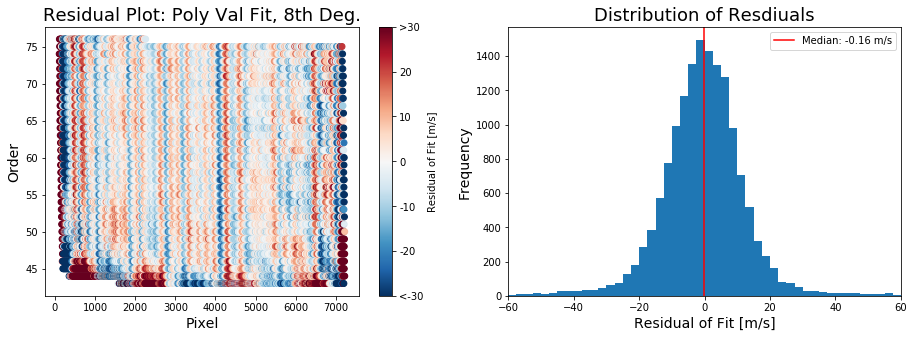

In [10]:
# Residual Plot and Histogram
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
plt.title('Residual Plot: Poly Val Fit, 8th Deg.',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=polyVal_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r')
cbar = plt.colorbar(label='Residual of Fit [m/s]')
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.subplot(122)
plt.title('Distribution of Resdiuals',fontsize=title_font)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(polyVal_resid_rv,np.arange(-100,100,2.5))
resid_med = np.median(polyVal_resid_rv)
plt.axvline(resid_med,color='r',
           label='Median: {:.3} m/s'.format(resid_med))
plt.legend()
plt.xlim(-60,60)
plt.tight_layout()
plt.savefig('./Figures/Paper/polyval2d.png')
plt.savefig('./Figures/Paper/polyval2d.pdf')

In [11]:
# Polynomial Fitting with Design Matrix
# Read in Data
x,m,w,e = readParams(ckpt_test)

# Fit
# Determine even lines from odd lines and vice versa
even = np.arange(len(x)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

dsnM_w_fit = np.zeros_like(w)
dsnM_w_fit[IA] = poly_train_and_predict(x[IA], m[IA], x[IB], m[IB], w[IB], 1/e[IB]**2, 8)
dsnM_w_fit[IB] = poly_train_and_predict(x[IB], m[IB], x[IA], m[IA], w[IA], 1/e[IA]**2, 8)

#dsnM_w_fit = poly_train_and_predict(x, m, x, m, w, 1/e**2, 8)

# Residuals
dsnM_resid_px = dsnM_w_fit-w
dsnM_resid_rv = dsnM_resid_px/w*c.value

fit(): condition number: 3.45e+05
fit(): condition number: 3.43e+05


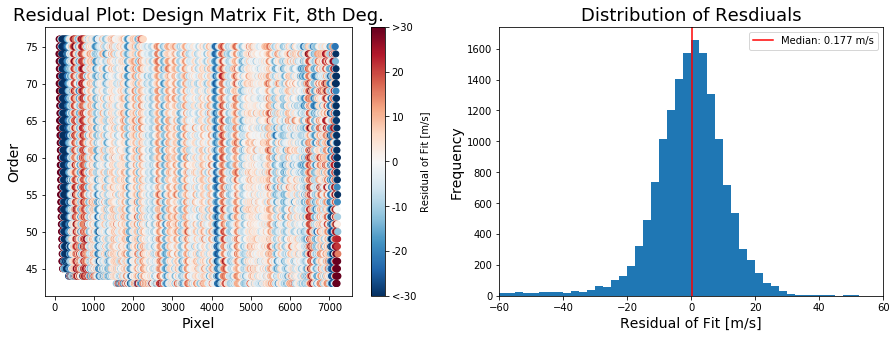

In [12]:
# Residual Plot and Histogram
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
plt.title('Residual Plot: Design Matrix Fit, 8th Deg.',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=dsnM_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r')
cbar = plt.colorbar(label='Residual of Fit [m/s]')
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.subplot(122)
plt.title('Distribution of Resdiuals',fontsize=title_font)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(dsnM_resid_rv,np.arange(-100,100,2.5))
resid_med = np.median(dsnM_resid_rv)
plt.axvline(resid_med,color='r',
           label='Median: {:.3} m/s'.format(resid_med))
plt.legend()
plt.xlim(-60,60)
plt.tight_layout()
plt.savefig('./Figures/Paper/designMatrix.png')
plt.savefig('./Figures/Paper/designMatrix.pdf')

### Non-Hierarchical Model

In [13]:
# Polynomial Fitting with Design Matrix
# Read in Data
x,m,w,e = readParams(ckpt_test)

# Fit
# Interp even lines from odd lines and vice versa
even = np.arange(len(x)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

intp_w_fit = np.zeros_like(w)
intp_w_fit[IA] = interp_train_and_predict(x[IA], m[IA], x[IB], m[IB], w[IB], e[IB])
intp_w_fit[IB] = interp_train_and_predict(x[IB], m[IB], x[IA], m[IA], w[IA], e[IA])

# Residuals
intp_resid_px = intp_w_fit-w
intp_resid_rv = intp_resid_px/w*c.value

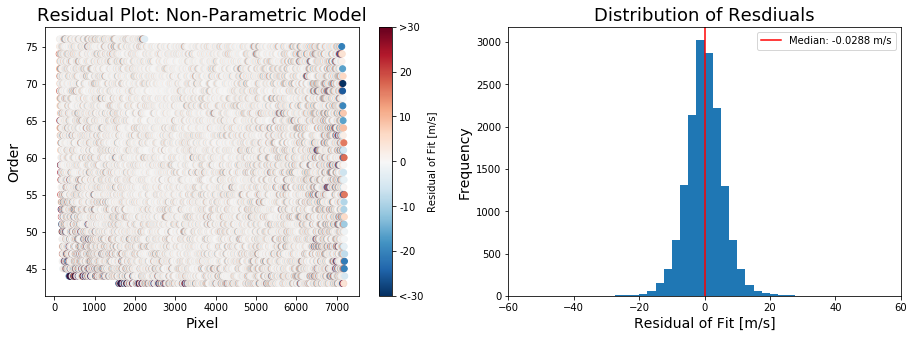

In [14]:
# Residual Plot and Histogram
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
plt.title('Residual Plot: Non-Parametric Model',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=intp_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r')
cbar = plt.colorbar(label='Residual of Fit [m/s]')
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.subplot(122)
plt.title('Distribution of Resdiuals',fontsize=title_font)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(intp_resid_rv[np.isfinite(intp_resid_rv)],np.arange(-100,100,2.5))
resid_med = np.nanmedian(intp_resid_rv)
plt.axvline(resid_med,color='r',
           label='Median: {:.3} m/s'.format(resid_med))
plt.legend()
plt.xlim(-60,60)
plt.tight_layout()
plt.savefig('./Figures/Paper/noHierc.png')
plt.savefig('./Figures/Paper/noHierc.pdf')